In [1962]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [1963]:
df = pd.read_csv("house-e1.csv")

In [1964]:
df.head(10)

title                                           address  \
0  2 bed flat for sale                            Orsman Road, London N1   
1  2 bed flat for sale                             Grove Road, London E3   
2  3 bed flat for sale                       Weymouth Terrace, London E2   
3  1 bed flat for sale                        Balmoral House, London SE1   
4  1 bed flat for sale       Lexicon, Book House, City Road, London EC1V   
5  1 bed flat for sale  Royal Victoria Gardens, Whiting Way, London SE16   
6  2 bed flat for sale                          Candle Street, London E1   
7  2 bed flat for sale                         Stainsby Road, London E14   
8  1 bed flat for sale       Lexicon, Book House, City Road, London EC1V   
9  1 bed flat for sale       Claremont House, 28 Quebec Way, London SE16   

        price  bed  bath  reception  
0    £540,000    2     1          1  
1    £500,000    2     1          1  
2    £425,000    3     1          1  
3  £1,151,500    1     1          0  
4    £650,000    1     1          1  
5    £410,000    1     1          1  
6    £495,000    2     2          1  
7    £465,000    2     2          0  
8    £630,000    1     1          1  
9    £500,000    1     1          1

In [1965]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3516 entries, 0 to 3515
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      3516 non-null   object
 1   address    3516 non-null   object
 2   price      3516 non-null   object
 3   bed        3516 non-null   int64 
 4   bath       3516 non-null   int64 
 5   reception  3516 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 164.9+ KB


## Get Postcodes and areas

In [1966]:
regex = re.compile("[A-Z]{2}[0-9]{2}|[A-Z]{2}[0-9]{1}|[A-Z]{1}[0-9]{2}|[A-Z]{1}[0-9]{1}")

In [1967]:
def get_district_code(address):
    post = regex.search(address)
    return post.group()

In [1968]:
df['Postcode'] = df['address'].apply(get_district_code)

In [1969]:
df.head(10)

title                                           address  \
0  2 bed flat for sale                            Orsman Road, London N1   
1  2 bed flat for sale                             Grove Road, London E3   
2  3 bed flat for sale                       Weymouth Terrace, London E2   
3  1 bed flat for sale                        Balmoral House, London SE1   
4  1 bed flat for sale       Lexicon, Book House, City Road, London EC1V   
5  1 bed flat for sale  Royal Victoria Gardens, Whiting Way, London SE16   
6  2 bed flat for sale                          Candle Street, London E1   
7  2 bed flat for sale                         Stainsby Road, London E14   
8  1 bed flat for sale       Lexicon, Book House, City Road, London EC1V   
9  1 bed flat for sale       Claremont House, 28 Quebec Way, London SE16   

        price  bed  bath  reception Postcode  
0    £540,000    2     1          1       N1  
1    £500,000    2     1          1       E3  
2    £425,000    3     1          1       E2  
3  £1,151,500    1     1          0      SE1  
4    £650,000    1     1          1      EC1  
5    £410,000    1     1          1     SE16  
6    £495,000    2     2          1       E1  
7    £465,000    2     2          0      E14  
8    £630,000    1     1          1      EC1  
9    £500,000    1     1          1     SE16

In [1970]:
df.Postcode.describe()

count     3516
unique      15
top         E1
freq       852
Name: Postcode, dtype: object

In [1971]:
df.Postcode.value_counts()

E1      852
EC2     415
E14     402
E3      368
EC1     308
E2      297
N1      282
SE1     270
SE16    205
E9       35
E8       34
EC3      29
EC4      14
E15       3
N4        2
Name: Postcode, dtype: int64

In [1972]:
df = df.groupby('Postcode').filter(lambda x : len(x)>10)

In [1973]:
df.Postcode.value_counts()

E1      852
EC2     415
E14     402
E3      368
EC1     308
E2      297
N1      282
SE1     270
SE16    205
E9       35
E8       34
EC3      29
EC4      14
Name: Postcode, dtype: int64

## Price

In [1974]:
#drop prices that were dedlared "POA" on Zoopla
print(sum(df.price == 'POA'))
df.drop(index=df[df['price'] == "POA"].index, inplace=True)
print(sum(df.price == 'POA'))

10
0


In [1975]:
def convert_price(price):
    price = price.replace("£",'').replace(",","")
    return pd.to_numeric(price)

In [1976]:
df['Price'] = df['price'].apply(convert_price)

In [1977]:
#df.drop(index=df[df['Price'] >= 5000000].index, inplace=True)

## Get Property Types

In [1978]:
#df[df['title'] == "Land for sale"]
#df.drop(index=df[df['title'] == "Land for sale"].index, inplace=True)

In [1979]:
property_types = ["semi-detached house","terraced house","flat","detached house","studio","maisonette",
                  "terrace house","bungalow","cottage","house","lodge","mobile"]
property_var = ["terrace house","semi detached house"]
property_dict = {"terrace house":"terraced house","semi detached house":"semi-detached house"}

In [1980]:
def get_property_type(title):
    for property_ in property_types:
        if property_ in title.lower():
            if property_ in property_var:
                return property_dict[property_].title().replace(" ","")
            return property_.lower().replace("-"," ").title().replace(" ","")
    return "Undefined"

In [1981]:
df['Type'] = df['title'].apply(get_property_type)

In [1982]:
df['Type'].value_counts()

Flat                 3034
Maisonette            133
Studio                120
TerracedHouse         102
House                  41
Undefined              38
DetachedHouse          21
SemiDetachedHouse      12
Name: Type, dtype: int64

In [1983]:
res = df[df['Type'] == 'Undefined']
res.head()

title                       address       price  bed  \
57   5 bed property for sale     Rampart Street, London E1  £2,850,000    5   
285  3 bed property for sale    Bow Common Lane, London E3    £850,000    3   
288  4 bed property for sale  Southborough Road, London E9  £1,100,000    4   
442  3 bed property for sale        Swaton Road, London E3    £775,000    3   
590  3 bed property for sale        Reeves Road, London E3    £600,000    3   

     bath  reception Postcode    Price       Type  
57      0          0       E1  2850000  Undefined  
285     1          2       E3   850000  Undefined  
288     2          1       E9  1100000  Undefined  
442     1          1       E3   775000  Undefined  
590     1          1       E3   600000  Undefined

## Beds


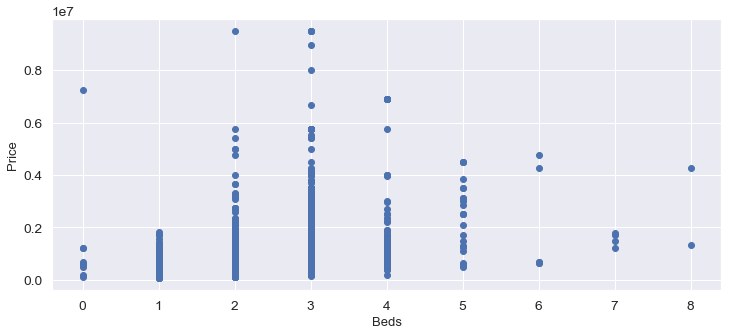

In [1984]:
#From kaggle forum and data description we have outliers
fig, ax = plt.subplots(figsize=(12,5));
ax.scatter(x = df['bed'], y = df['Price']);
plt.ylabel('Price', fontsize=13);
plt.xlabel('Beds', fontsize=13);
plt.show();

In [1985]:
#bed = 0 means land for sale sp drop
#df = df.drop(df[(df['bed']==0)].index);
#df = df.drop(df[(df['bed']==9)].index);

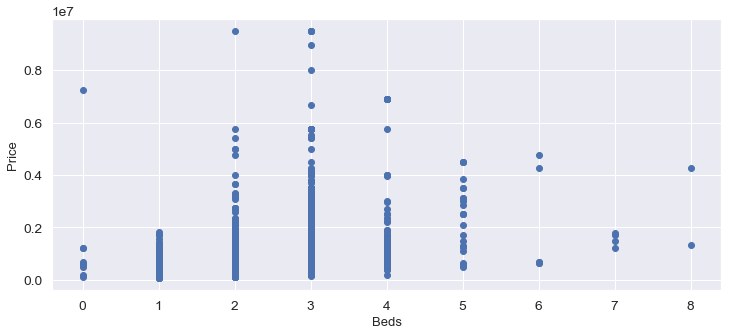

In [1986]:
fig, ax = plt.subplots(figsize=(12,5));
ax.scatter(x = df['bed'], y = df['Price']);
plt.ylabel('Price', fontsize=13);
plt.xlabel('Beds', fontsize=13);
plt.show();

## Bath

In [1987]:
df

title  \
0         2 bed flat for sale   
1         2 bed flat for sale   
2         3 bed flat for sale   
3         1 bed flat for sale   
4         1 bed flat for sale   
...                       ...   
3511  Terraced house for sale   
3512      1 bed flat for sale   
3513      2 bed flat for sale   
3514      1 bed flat for sale   
3515      2 bed flat for sale   

                                              address       price  bed  bath  \
0                              Orsman Road, London N1    £540,000    2     1   
1                               Grove Road, London E3    £500,000    2     1   
2                         Weymouth Terrace, London E2    £425,000    3     1   
3                          Balmoral House, London SE1  £1,151,500    1     1   
4         Lexicon, Book House, City Road, London EC1V    £650,000    1     1   
...                                               ...         ...  ...   ...   
3511                      White Horse Lane, London E1    £100,000    0     0   
3512     Balmoral House, Earl's Way, Tower Bridge SE1  £1,550,000    1     1   
3513              The Heron, Moor Lane, Barbican EC2Y  £1,800,000    2     2   
3514  Meranti House, Leman Street, Aldgate, London E1    £675,000    1     0   
3515   Chatsworth House, One Tower Bridge, London SE1  £1,350,000    2     2   

      reception Postcode    Price           Type  
0             1       N1   540000           Flat  
1             1       E3   500000           Flat  
2             1       E2   425000           Flat  
3             0      SE1  1151500           Flat  
4             1      EC1   650000           Flat  
...         ...      ...      ...            ...  
3511          0       E1   100000  TerracedHouse  
3512          1      SE1  1550000           Flat  
3513          1      EC2  1800000           Flat  
3514          0       E1   675000           Flat  
3515          1      SE1  1350000           Flat  

[3501 rows x 9 columns]

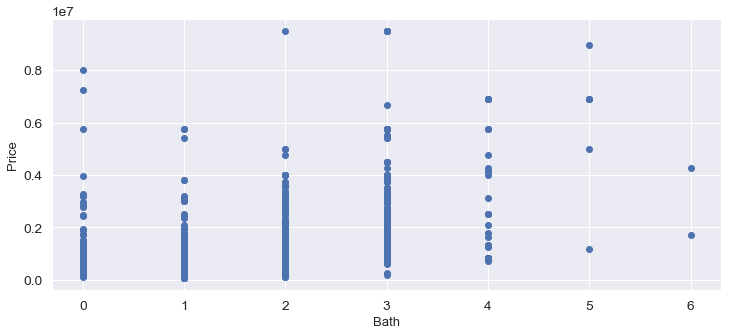

In [1988]:
fig, ax = plt.subplots(figsize=(12,5));
ax.scatter(x = df['bath'], y = df['Price']);
plt.ylabel('Price', fontsize=13);
plt.xlabel('Bath', fontsize=13);
plt.show();

In [1989]:
df[df['bath'] == 0]

title  \
44                  Studio for sale   
57          5 bed property for sale   
80              1 bed flat for sale   
146             3 bed flat for sale   
208   2 bed terraced house for sale   
...                             ...   
3474            1 bed flat for sale   
3489            2 bed flat for sale   
3500            1 bed flat for sale   
3511        Terraced house for sale   
3514            1 bed flat for sale   

                                              address       price  bed  bath  \
44         Sheppard House Warner Place, Shoreditch E2    £220,000    1     0   
57                          Rampart Street, London E1  £2,850,000    5     0   
80                        Dunbridge Street, London E2    £675,000    1     0   
146                            City Road, London EC1V  £1,950,000    3     0   
208                       Baxendale Street, London E2    £750,000    2     0   
...                                               ...         ...  ...   ...   
3474               Chronicle Tower 261 City Road EC1V    £780,000    1     0   
3489               Chronicle Tower 261 City Road EC1V  £1,100,000    2     0   
3500                The Heron, 5 Moor Ln, London EC2Y    £825,000    1     0   
3511                      White Horse Lane, London E1    £100,000    0     0   
3514  Meranti House, Leman Street, Aldgate, London E1    £675,000    1     0   

      reception Postcode    Price           Type  
44            0       E2   220000         Studio  
57            0       E1  2850000      Undefined  
80            0       E2   675000           Flat  
146           0      EC1  1950000           Flat  
208           0       E2   750000  TerracedHouse  
...         ...      ...      ...            ...  
3474          0      EC1   780000           Flat  
3489          0      EC1  1100000           Flat  
3500          0      EC2   825000           Flat  
3511          0       E1   100000  TerracedHouse  
3514          0       E1   675000           Flat  

[155 rows x 9 columns]

## Reception

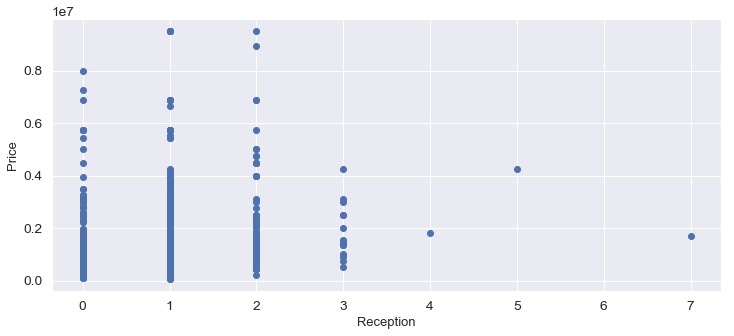

In [1990]:
#From kaggle forum and data description we have outliers
fig, ax = plt.subplots(figsize=(12,5));
ax.scatter(x = df['reception'], y = df['Price']);
plt.ylabel('Price', fontsize=13);
plt.xlabel('Reception', fontsize=13);
plt.show();

In [1991]:
df['reception'].value_counts()

1    2821
0     548
2     111
3      18
7       1
5       1
4       1
Name: reception, dtype: int64

## HeatMap

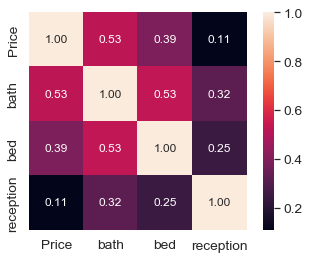

In [1992]:
#lets look at correlation between price and other variables
k = 10 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Log Price

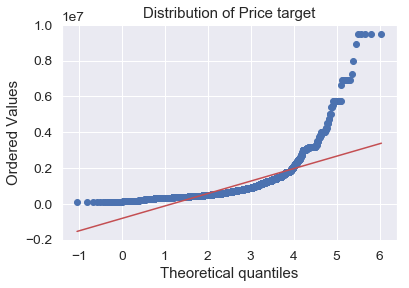

In [1993]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(df['Price'], dist='norm', sparams=(2.5,), plot=ax)
ax.set_title("Distribution of Price target")
plt.show();

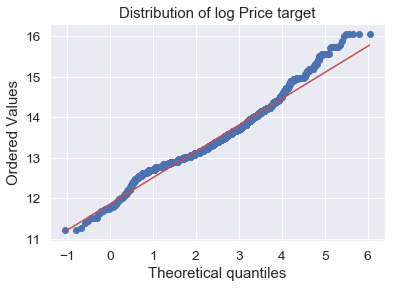

In [1994]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(np.log1p(df['Price']), dist='norm', sparams=(2.5,), plot=ax)
ax.set_title("Distribution of log Price target")
plt.show();

In [1995]:
df["Price"] = np.log1p(df["Price"])

## Get Bed, Bath, Reception

In [1996]:
df = df.rename(columns={"bed": "Bed", "bath": "Bath","reception":"Reception"})

In [1997]:
df = df.drop(['title', 'address','price'], axis=1)

In [1998]:
df.head()

Bed  Bath  Reception Postcode      Price  Type
0    2     1          1       N1  13.199326  Flat
1    2     1          1       E3  13.122365  Flat
2    3     1          1       E2  12.959847  Flat
3    1     1          0      SE1  13.956577  Flat
4    1     1          1      EC1  13.384729  Flat

In [1999]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3501 entries, 0 to 3515
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Bed        3501 non-null   int64  
 1   Bath       3501 non-null   int64  
 2   Reception  3501 non-null   int64  
 3   Postcode   3501 non-null   object 
 4   Price      3501 non-null   float64
 5   Type       3501 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 191.5+ KB


## Categorize

In [2000]:
#df = df.rename(columns={"PostcodeArea": "Area","PropertyType": "PropType"})
df = pd.get_dummies(df, columns=['Type','Postcode'],prefix_sep='')

In [2001]:
#df = df.rename(columns={"PropertyType": "PropType"})
#df = pd.get_dummies(df, columns=['PropType'])

In [2002]:
df.head()

Bed  Bath  Reception      Price  TypeDetachedHouse  TypeFlat  TypeHouse  \
0    2     1          1  13.199326                  0         1          0   
1    2     1          1  13.122365                  0         1          0   
2    3     1          1  12.959847                  0         1          0   
3    1     1          0  13.956577                  0         1          0   
4    1     1          1  13.384729                  0         1          0   

   TypeMaisonette  TypeSemiDetachedHouse  TypeStudio  ...  PostcodeE3  \
0               0                      0           0  ...           0   
1               0                      0           0  ...           1   
2               0                      0           0  ...           0   
3               0                      0           0  ...           0   
4               0                      0           0  ...           0   

   PostcodeE8  PostcodeE9  PostcodeEC1  PostcodeEC2  PostcodeEC3  PostcodeEC4  \
0           0           0            0            0            0            0   
1           0           0            0            0            0            0   
2           0           0            0            0            0            0   
3           0           0            0            0            0            0   
4           0           0            1            0            0            0   

   PostcodeN1  PostcodeSE1  PostcodeSE16  
0           1            0             0  
1           0            0             0  
2           0            0             0  
3           0            1             0  
4           0            0             0  

[5 rows x 25 columns]

In [2003]:
df.shape

(3501, 25)

## HeatMap

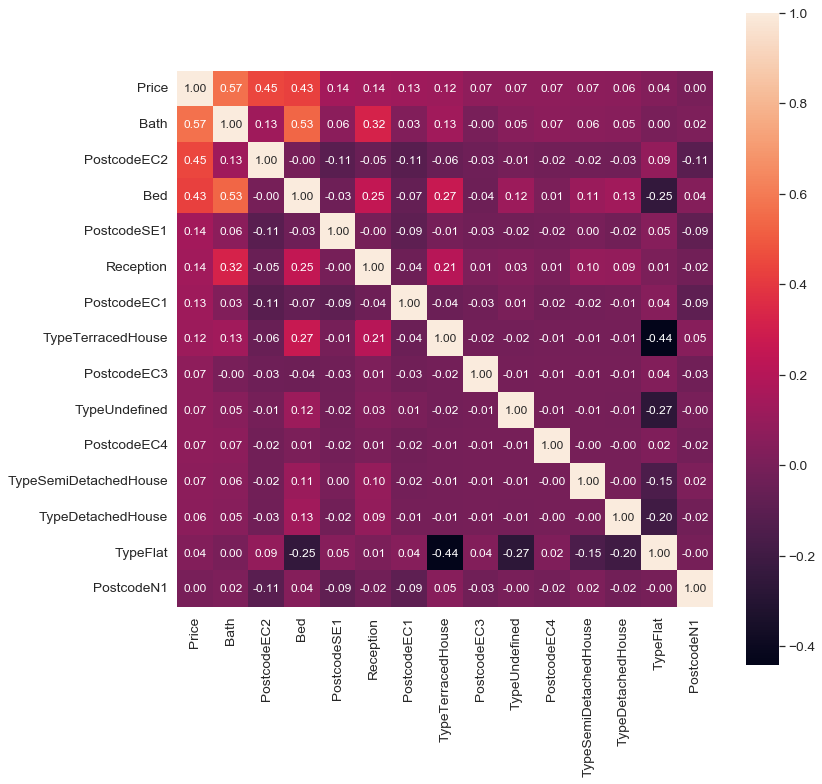

In [2004]:
k = 15 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(12,12)) 
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Discussion
- We have a small dataset so likely to overtfit, better to use simpler algo like Linear Regression
- Most of the features are similar, so lack of variance in dataset, e.g. bed, bath, reception all similar values
- No strong correlation to price, most features around zero mark
- Given these factors unlikely to achieve very good results.  Would need more data 

In [2005]:
#from sklearn.preprocessing import PolynomialFeatures
#from pandas import DataFrame
#df1 = df.iloc[:, 0:3]
#data = df1.values
#trans = PolynomialFeatures(degree=2)
#data = trans.fit_transform(data)
#data.shape

In [2006]:
#dataset = DataFrame(data)
#df_concat = pd.concat([df, dataset], axis=1)
#df = df_concat
#df.dropna(inplace=True)  

In [2007]:
#df.isnull().sum()

## Predict

In [2008]:
X = df.drop('Price',axis='columns')
X.head()

Bed  Bath  Reception  TypeDetachedHouse  TypeFlat  TypeHouse  \
0    2     1          1                  0         1          0   
1    2     1          1                  0         1          0   
2    3     1          1                  0         1          0   
3    1     1          0                  0         1          0   
4    1     1          1                  0         1          0   

   TypeMaisonette  TypeSemiDetachedHouse  TypeStudio  TypeTerracedHouse  ...  \
0               0                      0           0                  0  ...   
1               0                      0           0                  0  ...   
2               0                      0           0                  0  ...   
3               0                      0           0                  0  ...   
4               0                      0           0                  0  ...   

   PostcodeE3  PostcodeE8  PostcodeE9  PostcodeEC1  PostcodeEC2  PostcodeEC3  \
0           0           0           0            0            0            0   
1           1           0           0            0            0            0   
2           0           0           0            0            0            0   
3           0           0           0            0            0            0   
4           0           0           0            1            0            0   

   PostcodeEC4  PostcodeN1  PostcodeSE1  PostcodeSE16  
0            0           1            0             0  
1            0           0            0             0  
2            0           0            0             0  
3            0           0            1             0  
4            0           0            0             0  

[5 rows x 24 columns]

In [2009]:
y = df.Price
y.head()

0    13.199326
1    13.122365
2    12.959847
3    13.956577
4    13.384729
Name: Price, dtype: float64

In [2010]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [.01,.1,0.5],
                'solver': ['auto', 'svd']
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [.001,.1],
                'selection': ['random', 'cyclic']
            }
        },
        'EN': {
            'model': ElasticNet(),
            'params': {
                'alpha': [.001,.1,0.5],
                'l1_ratio': [0.1,0.5, 0.75]
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random'],
                'min_samples_split':[5,10,50,100]
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

model  best_score  \
0  linear_regression    0.637880   
1              ridge    0.637777   
2              lasso    0.633414   
3                 EN    0.637171   
4      decision_tree    0.680123   

                                         best_params  
0                                {'normalize': True}  
1                  {'alpha': 0.01, 'solver': 'auto'}  
2            {'alpha': 0.001, 'selection': 'random'}  
3                  {'alpha': 0.001, 'l1_ratio': 0.1}  
4  {'criterion': 'mse', 'min_samples_split': 10, ...

In [2011]:
config = {  'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random'],
                 'min_samples_split':[5,10,50,100],
            }
}

cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
dt_clf = GridSearchCV(estimator=config['model'], param_grid=config['params'], cv=cv)
dt_clf.fit(X,y)
print(dt_clf.best_score_)
print(dt_clf)

0.6682279170651447
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
       error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['mse', 'friedman_mse'], 'splitter': ['best', 'random'], 'min_samples_split': [5, 10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


In [2012]:
df.columns

Index(['Bed', 'Bath', 'Reception', 'Price', 'TypeDetachedHouse', 'TypeFlat',
       'TypeHouse', 'TypeMaisonette', 'TypeSemiDetachedHouse', 'TypeStudio',
       'TypeTerracedHouse', 'TypeUndefined', 'PostcodeE1', 'PostcodeE14',
       'PostcodeE2', 'PostcodeE3', 'PostcodeE8', 'PostcodeE9', 'PostcodeEC1',
       'PostcodeEC2', 'PostcodeEC3', 'PostcodeEC4', 'PostcodeN1',
       'PostcodeSE1', 'PostcodeSE16'],
      dtype='object')

In [2013]:
import joblib
joblib.dump(dt_clf, 'model_file_name.pkl')

['model_file_name.pkl']

In [2014]:
dt_mod = joblib.load("model_file_name.pkl")

In [2015]:
def predict_price(model,location,proptype,bed,bath,reception):    
    loc_index = np.where(X.columns==location)[0][0]
    loc_index2 = np.where(X.columns==proptype)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = bed
    x[1] = bath
    x[2] = reception
    x[loc_index] = 1
    x[loc_index2] = 1
    print(x)

    return np.expm1(model.predict([x])[0])

In [2016]:
predict_price(dt_mod,'PostcodeE14','TypeDetachedHouse',2, 1, 1)

[2. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


905521.6227525498

In [2017]:
predict_price(dt_mod,'PostcodeSE16','TypeFlat',3, 1, 1)

[3. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


510512.278850192